In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from keras.models import Model
from keras import preprocessing, Input
import os
import itertools
import numpy as np
from PIL import Image, ImageFile

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
EMAIL = re.compile('^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$')
# NUMBERS = re.compile(['0-9'])
STOPWORDS = set(stopwords.words('english'))

In [ ]:
Training_path = "/content/drive/MyDrive/Project/Project/Dataset/Split Dataset/Training_meme_dataset.csv"
Validation_path = "/content/drive/MyDrive/Project/Project/Dataset/Split Dataset/Validation_meme_dataset.csv"
Testing_path = "/content/drive/MyDrive/Project/Project/Dataset/Split Dataset/Testing_meme_dataset.csv"
img_dir = "/content/drive/MyDrive/Project/Project/Dataset/Labelled Images"

In [ ]:
# For vectors
maxlen = 1000

In [ ]:
def encode_label(DataFrame, Label_col):
    t_y = DataFrame[Label_col].values
    Encoder = LabelEncoder()
    y = Encoder.fit_transform(t_y)
    DataFrame[Label_col] = y

In [ ]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = EMAIL.sub('', text)
#     text = NUMBERS.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)    
    text = text.replace('x','')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [ ]:
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '/' + file
            all_imgs.append(file)
    return all_imgs

In [ ]:
def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '/' + name for name in DF[Col_name]]
    return img_path
    

In [ ]:
def preprocess_text(Training_path,Validation_path, Testing_path):
    # function to preprocess input
    training_DF = pd.read_csv(Training_path, sep = ',')
    validation_DF = pd.read_csv(Validation_path, sep = ',')
    testing_DF = pd.read_csv(Testing_path, sep = ',')

    # encoding all the labels 
    encode_label(testing_DF,'label')
    encode_label(training_DF, 'label')
    encode_label(validation_DF, 'label')

    clean_text(training_DF['sentence'][0])

    # Processing the text
    training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
    testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
    validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

    return training_DF, testing_DF, validation_DF

In [ ]:
def get_input(path):
    # Loading image from given path
    # and resizing it to 224*224*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = image.load_img(path, target_size=(224,224))    
    return(img)

In [ ]:
# Function to get the output
# returns an array of labels
def get_output(path,label_file=None):
    # Spliting the path and take out the image id    
    filename = path.split('/')[-1]
    # Taking list of labels
    labels = list(label_file[label_file['image_name'] == filename]['label'].values)
    # for duplicate selecting labels
    if len(labels) <= 2:
        label = labels[0]
    elif len(labels) > 2:
        uni_label = list(set(labels))
        count_label = [labels.count(lab) for lab in uni_label]
        lab_idx = count_label.index(max(count_label))
        label = uni_label[lab_idx]
    return label

In [ ]:
# Takes in image and preprocess it
def process_input(img):
    # Converting image to array    
    img_data = image.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    return(img_data)

In [ ]:
# Function to generate the data
def image_generator(files,label_file, batch_size = None):   
    """
        files: list of image paths 
        label_file: labels of the observations
        batch_size: Number of observations to be selected at a time
        
        return: generator object of image data
    """
    idxs = list(range(len(files)))
    idx = 0
    while True: 
        batch_paths = files[idx:idx+batch_size]
#         batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = [] # Batch input initialization
        batch_output = [] # Batch output initialization
          
        # Read in each input, perform preprocessing and get labels    
        for input_path in batch_paths:
            input = get_input(input_path ) # Load image
            output = get_output(input_path,label_file=label_file ) # Load label of the image
            input = process_input(img=input) # Process the image
            batch_input.append(input[0]) # Append the image
            batch_output.append(output)  # Append the label
            
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [ ]:
def text_generator(padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    idxs = list(range(len(y)))
    idx = 0
    while True:
        batch_idxs = idxs[idx:idx+batch_size]
        idx = idx + batch_size
#         batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input = [] # Initializing batch input
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label            
            batch_input.append(input) # Appending the input (text vector)
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [ ]:
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)

In [ ]:
import nltk 
from nltk.corpus import stopwords

In [ ]:
import sys
import os
py_path = "/content/drive/MyDrive/Project/Project"
sys.path.append(os.path.abspath(py_path))

In [ ]:
# Importing all the necessary libraries
import keras
import h5py
import pandas
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
# import keras_metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

In [ ]:
class_weight = {1: 1.4,
                0: 1.}

In [ ]:
# Storing directory of glove embeddings
GLOVE_DIR = "/content/drive/MyDrive/Project/Project/glove.6B"
EMBEDDING_DIM = 50

In [ ]:
# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)    
    return x

In [ ]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [ ]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [ ]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [ ]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [ ]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [ ]:
# Creating vocabulary with glove embeddings
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [ ]:
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [ ]:
#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

In [ ]:
# Defining input layer
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# Defining embedding layer which will encode the input sequence
embedded_sequences = embedding_layer(main_input)
# x = Embedding(output_dim=512, input_dim=10000, input_length=maxlen)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = (Bidirectional(LSTM(32)))(embedded_sequences)

# Output of text model
txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [ ]:
txt_model = Model(inputs = [main_input], outputs=txt_out)

In [ ]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

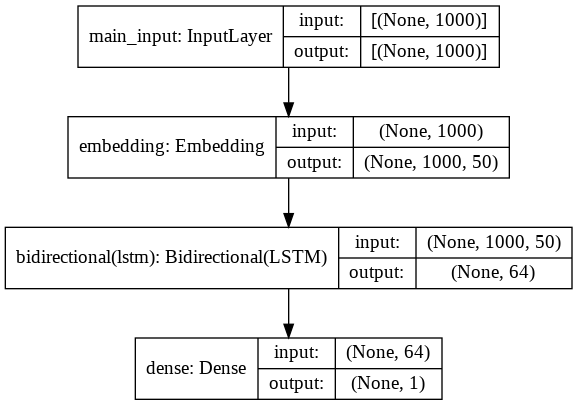

In [ ]:
plot_model(txt_model, to_file='BiLSTM_txt_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Training text model
txt_model.fit_generator(txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/7
2/2 [==============================] - 26s 8s/step - loss: 0.8300 - accuracy: 0.3854 - val_loss: 0.7151 - val_accuracy: 0.4228
Epoch 2/7
2/2 [==============================] - 7s 7s/step - loss: 0.8000 - accuracy: 0.3958 - val_loss: 0.7067 - val_accuracy: 0.4295
Epoch 3/7
2/2 [==============================] - 7s 7s/step - loss: 0.8062 - accuracy: 0.4062 - val_loss: 0.6967 - val_accuracy: 0.5302
Epoch 4/7
2/2 [==============================] - 7s 7s/step - loss: 0.8200 - accuracy: 0.4896 - val_loss: 0.6906 - val_accuracy: 0.5369
Epoch 5/7
2/2 [==============================] - 7s 7s/step - loss: 0.7893 - accuracy: 0.6042 - val_loss: 0.6868 - val_accuracy: 0.5973
Epoch 6/7
2/2 [==============================] - 7s 7s/step - loss: 0.7969 - accuracy: 0.5312 - val_loss: 0.6839 - val_accuracy: 0.6040
Epoch 7/7
2/2 [==============================

In [ ]:
txt_model.save('BiLSTM_txt_model.h5')

In [ ]:
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
y_true = y_test.values

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


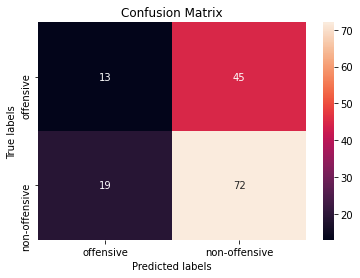

In [ ]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [ ]:
# create base model with imagenet weights
pre_trained_image_model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Building img_prediction layer using Image_model
base_img = Image_model(pre_trained_image_model)
img_prediction_layer = Dense(1, activation='sigmoid')(base_img)

In [ ]:
# Defining image model
img_model = Model(inputs = [pre_trained_image_model.input], outputs=img_prediction_layer)

In [ ]:
# Compiling image model
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

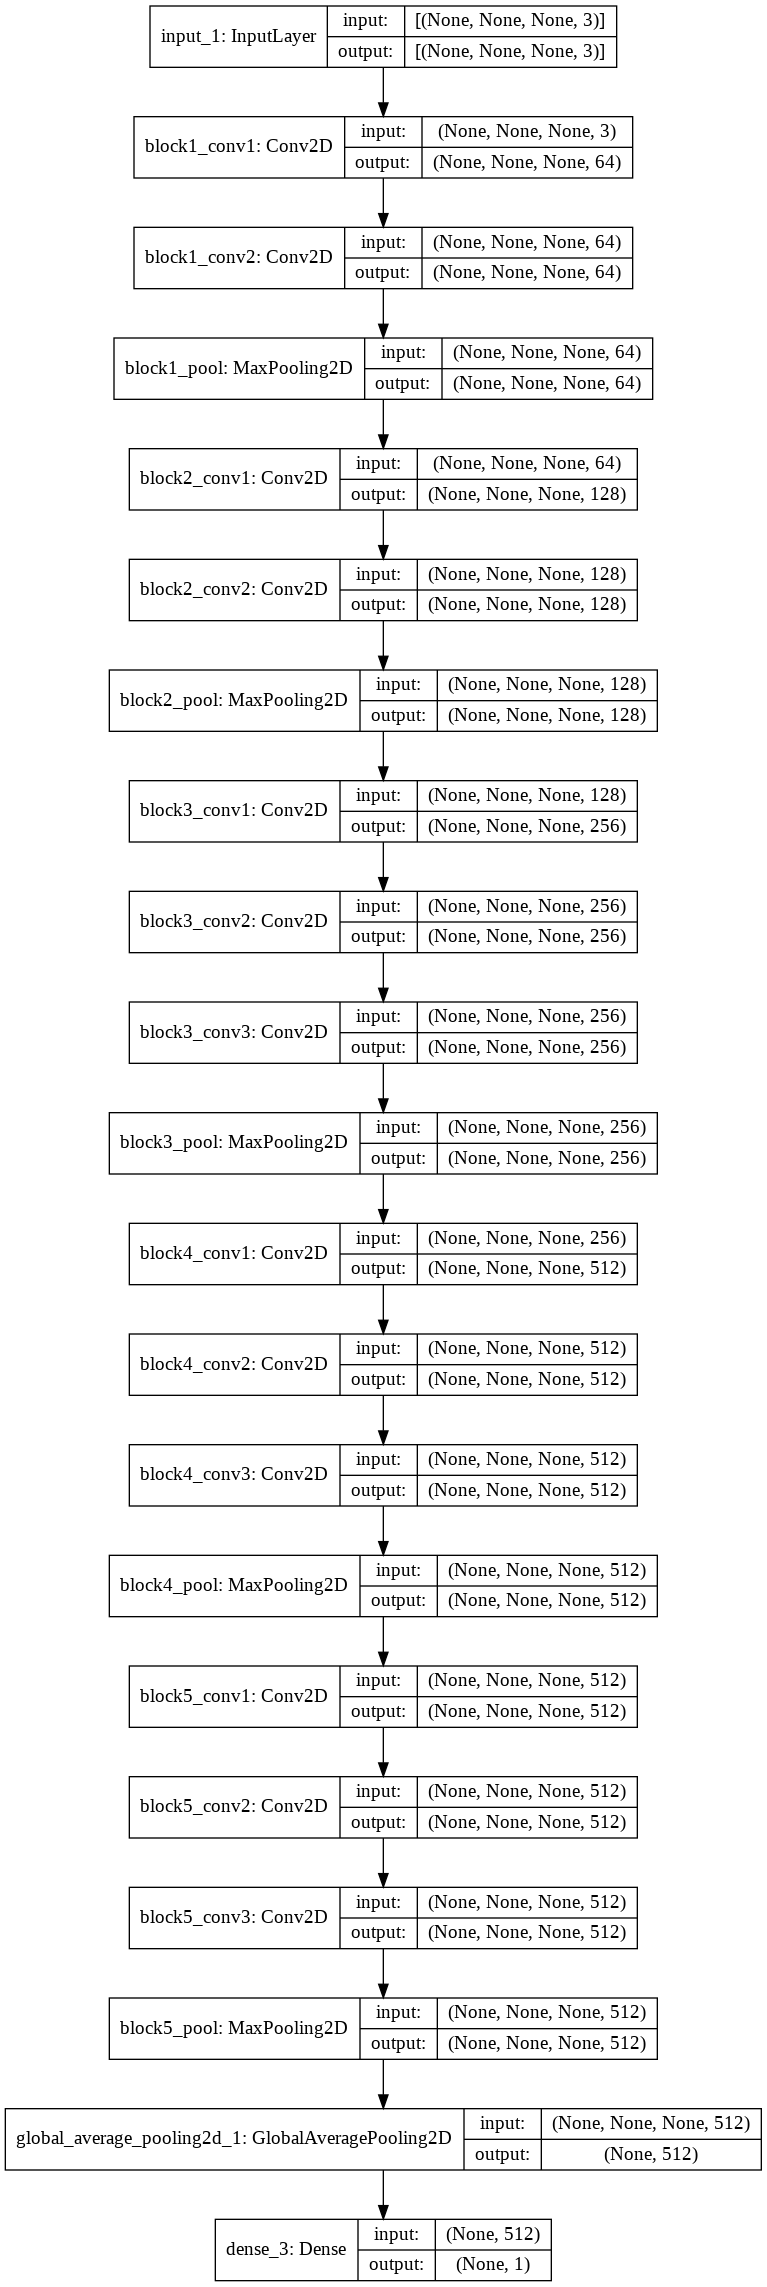

In [ ]:
# Plotting image model
plot_model(img_model, to_file='VGG16_img_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
img_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
# Training image model
img_model.fit(img_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 93s 77s/step - loss: 3.7563 - accuracy: 0.4792 - val_loss: 0.4949 - val_accuracy: 1.0000
Epoch 2/7
2/2 [==============================] - 89s 76s/step - loss: 2.9443 - accuracy: 0.5000 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 3/7
2/2 [==============================] - 89s 76s/step - loss: 2.1700 - accuracy: 0.4688 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/7
2/2 [==============================] - 89s 76s/step - loss: 1.7889 - accuracy: 0.5938 - val_loss: 2.7421e-04 - val_accuracy: 1.0000
Epoch 5/7
2/2 [==============================] - 89s 76s/step - loss: 1.7216 - accuracy: 0.6458 - val_loss: 1.4103e-04 - val_accuracy: 1.0000
Epoch 6/7
2/2 [==============================] - 89s 76s/step - loss: 1.6535 - accuracy: 0.6875 - val_loss: 2.1884e-04 - val_accuracy: 1.0000
Epoch 7/7
2/2 [==============================] - 89s 76s/step - loss: 1.4515 - accuracy: 0.6875 - val_loss: 7.7476e-04 - val_accuracy: 1.0000


In [ ]:
# Saving image model
img_model.save('VGG16_img_model.h5')

In [ ]:
# Predicting labels using image model
y_pred_img = (img_model.predict_generator(img_gen_test,steps = 149))
y_pred_img = np.round(list(itertools.chain(*y_pred_img)))
y_true = y_test.values

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


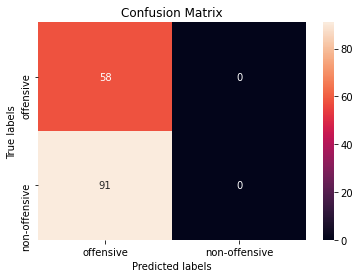

In [ ]:
# Confusion matrix for image classifier
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_img, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [ ]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [ ]:
# Concatenating the output
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [ ]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [ ]:
# Using Stochastic gradient descent with optimizer
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


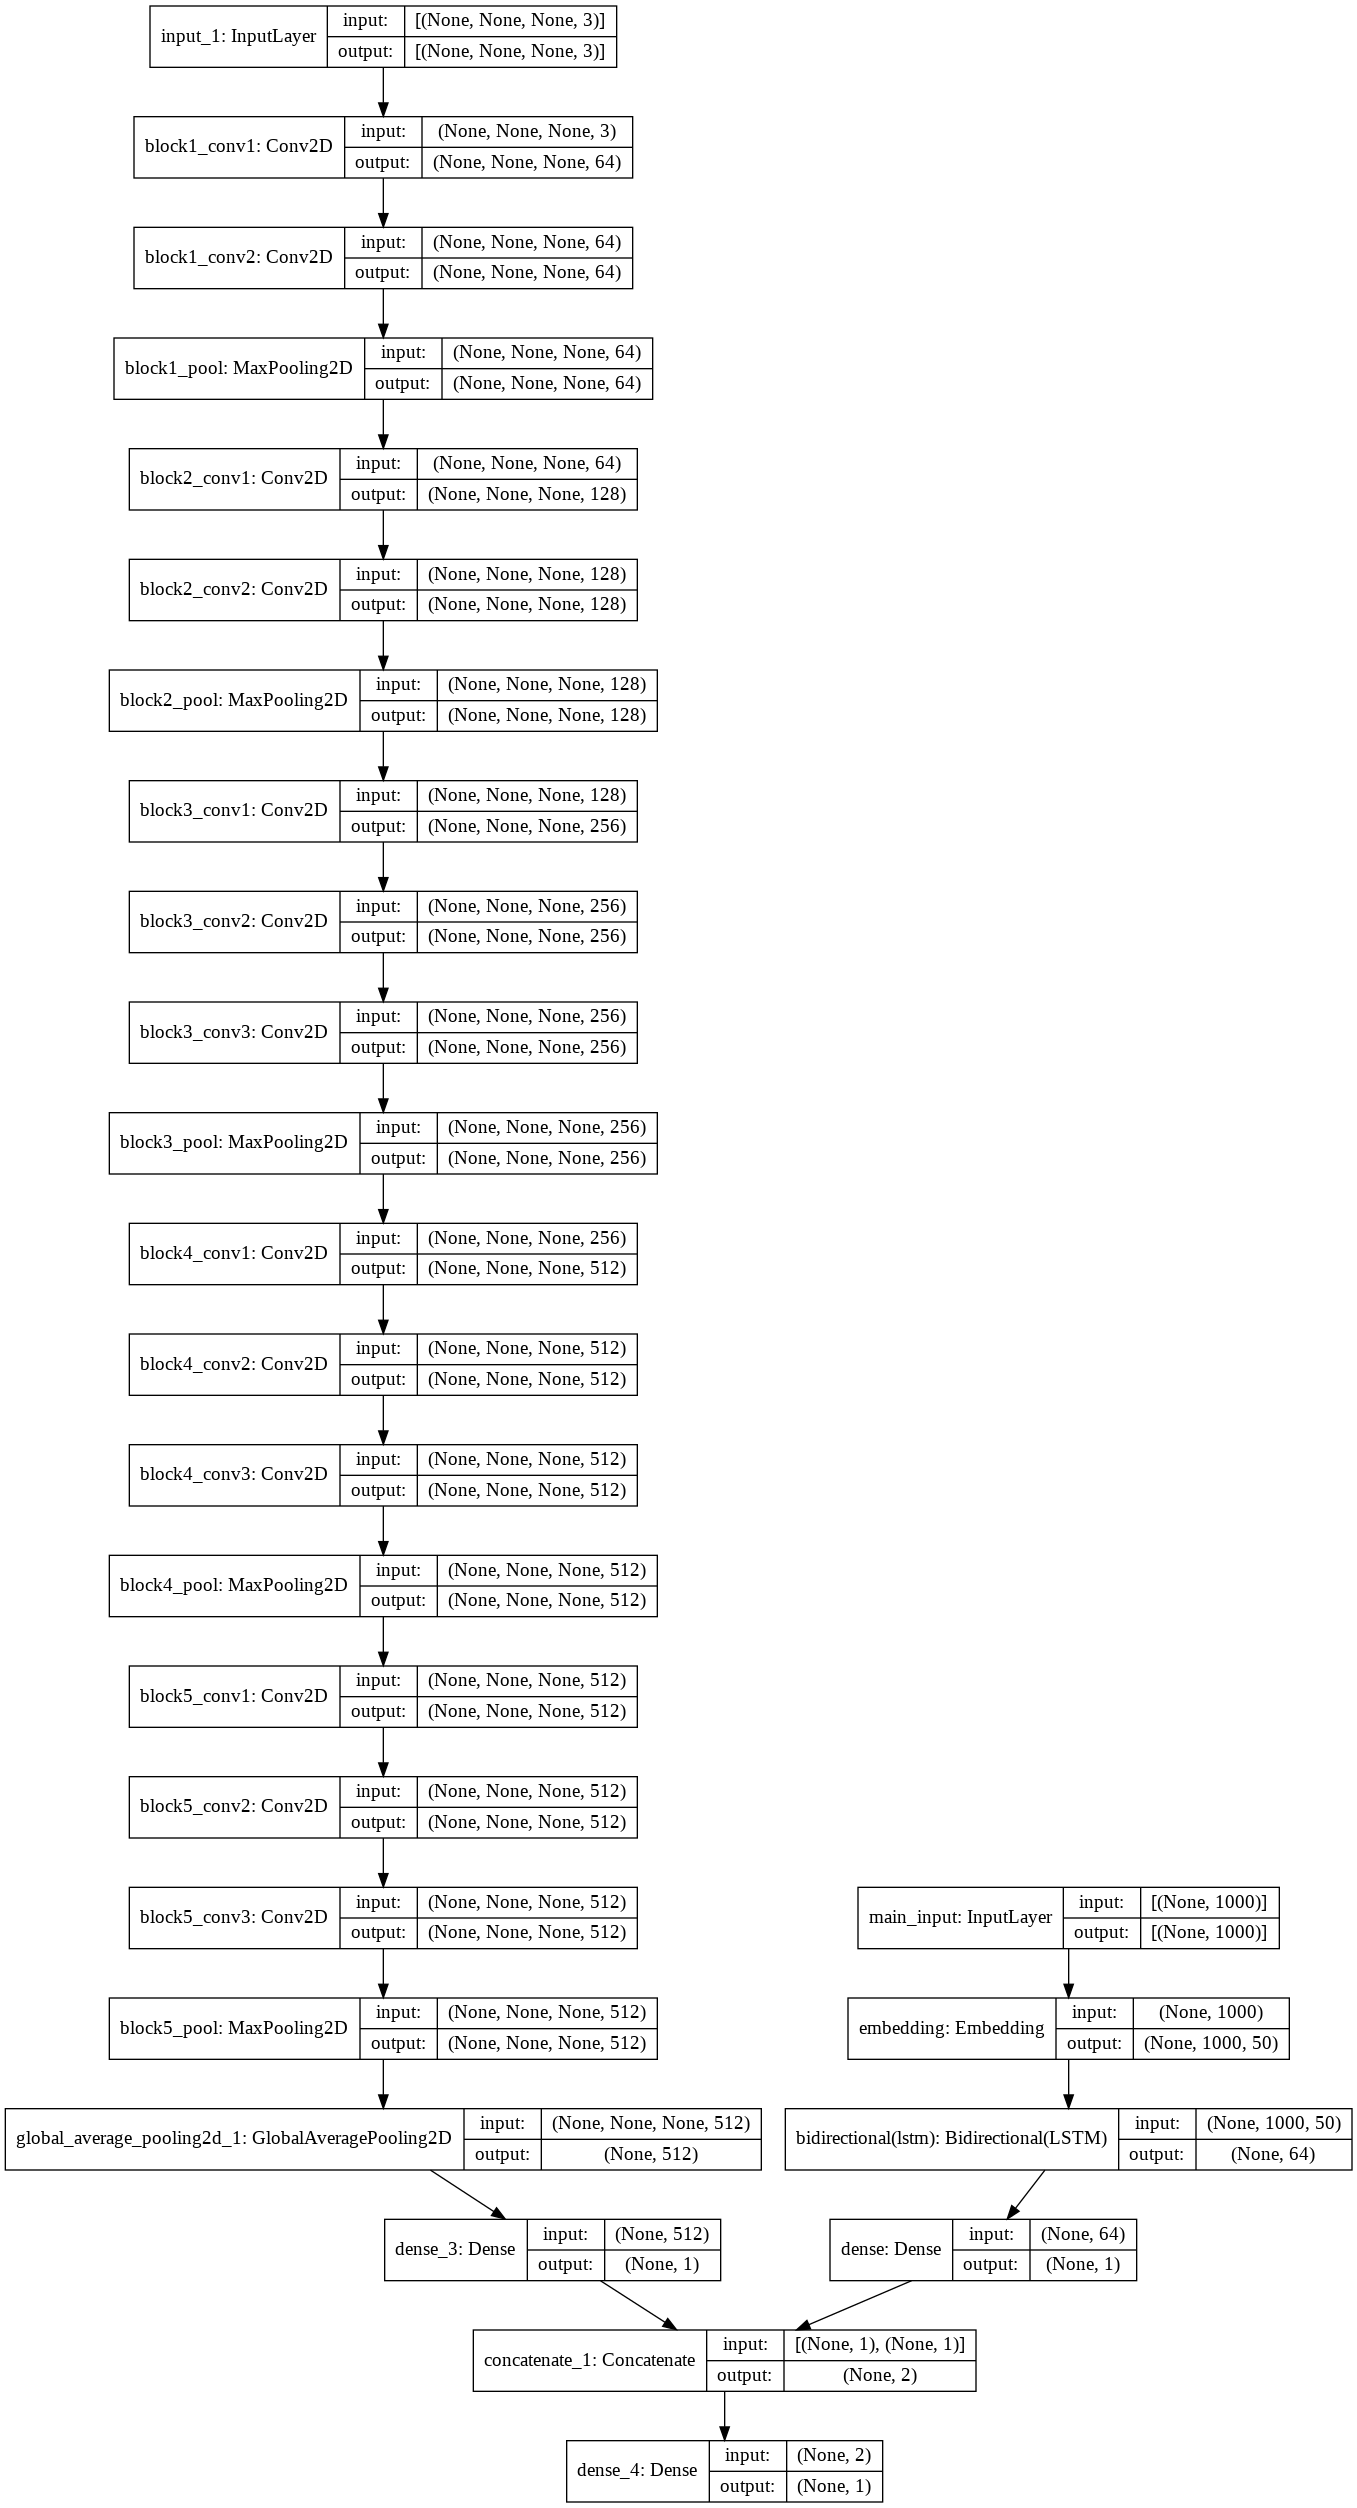

In [ ]:
# Plot the model
plot_model(com_model, to_file='BiLSTM_VGG_mul_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
com_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
2/2 [==============================] - 102s 83s/step - loss: 0.7659 - accuracy: 0.6250 - val_loss: 0.7484 - val_accuracy: 0.4966
Epoch 2/7
2/2 [==============================] - 94s 81s/step - loss: 0.8259 - accuracy: 0.4583 - val_loss: 0.7853 - val_accuracy: 0.3826
Epoch 3/7
2/2 [==============================] - 95s 82s/step - loss: 0.7890 - accuracy: 0.5938 - val_loss: 0.7654 - val_accuracy: 0.4497
Epoch 4/7
2/2 [==============================] - 95s 81s/step - loss: 0.8293 - accuracy: 0.5000 - val_loss: 0.7631 - val_accuracy: 0.4362
Epoch 5/7
2/2 [==============================] - 94s 81s/step - loss: 0.8660 - accuracy: 0.4062 - val_loss: 0.7459 - val_accuracy: 0.4295
Epoch 6/7
2/2 [==============================] - 95s 81s/step - loss: 0.7565 - accuracy: 0.6979 - val_loss: 0.7730 - val_accuracy: 0.3893
Epoch 7/7
2/2 [==============================] - 95s 81s/step - loss: 0.8200 - accuracy: 0.4688 - val_loss: 0.7627 - val_accuracy: 0.4228


In [ ]:
# Saving the text model
com_model.save('BiLSTM_VGG_mul_model.h5')

In [ ]:
# Predicting the label using combined model
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


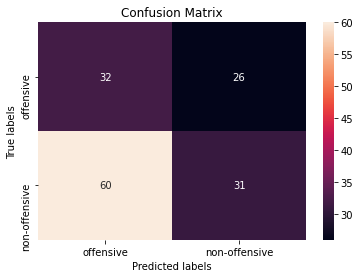

In [ ]:
# Block for confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.54385965, 0.34782609]),
 array([0.34065934, 0.55172414]),
 array([0.41891892, 0.42666667]),
 array([91, 58]))